# 8. Bifurcations in 2D systems

## Preamble

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline as interpolate
from scipy.optimize import root, fsolve
from scipy.misc import derivative
import scipy.linalg as lg

import sympy as sp
import fractions as fra

# install the tabulate module using: "conda install tabulate"
from tabulate import tabulate

from ipywidgets import interact

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib as mpl
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
%run -i "rcParameters.py"
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["font.family"]='Times New Roman'
plt.rcParams["mathtext.fontset"]='stix';

In [3]:
# set fontsize in markdown cells
from IPython.core.display import display, HTML, Latex
display(HTML("<style>.rendered_html { font-size: 16px; }</style>"))

## Utility functions

In [4]:
# chop(expr) = 0 if |expr| < delta
def chop(expr, delta=10**-10):
    return np.ma.masked_inside(expr, -delta, delta).filled(0)


In [5]:
# Bifurcation diagram: x vs r
def BF_diag(f,x1,x2,r1,r2,nx=80,nr=80,col='k',title='',x_lab='$r$',y_lab='$x^\star$'):
    fx = lambda x,r: derivative(f,x,dx=1e-6,args=(r,))
    x=np.linspace(x1,x2,nx)
    r=np.linspace(r1,r2,nr)
    R,X = np.meshgrid(r,x)
    Z = f(X,R)
    Zx= fx(X,R)
    Zu= np.ma.masked_where(Zx<0,Z)
    Zs= np.ma.masked_where(Zx>0,Z)

    fig, ax=plt.subplots(figsize=(6,4))
    ax.contour(R,X,Zs,levels=[0],colors=col,linewidths=3)
    ax.contour(R,X,Zu,levels=[0],colors=col,linewidths=3,linestyles='dashed')
    ax.grid()
    ax.set_xlabel(x_lab)
    ax.set_ylabel(y_lab)
    ax.set_title(title,color='b')
    plt.show()    

In [6]:
# Phase portrait: streamplot X,Y,Vx=dx/dt,Vy=dy/dt
def PP_2d(x1,x2,y1,y2,f1,f2,ax,nx=100,ny=100,dens=[1,1],lw=1,col='k'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)
    ax.streamplot(X,Y,U,V,density=dens,
                 linewidth=lw,color=col,arrowstyle='->')
    return ax

# Phase portrait: streamlines through selected points
def PP_2d_sp(x1,x2,y1,y2,f1,f2,seed_points,ax,nx=100,ny=100,dens=[1,1],lw=1,col='k',ar_s='->'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)    
    ax.streamplot(X,Y,U,V,density=dens,start_points=seed_points.T,
                 linewidth=lw,color=col,arrowstyle=ar_s)
    return ax    

# Phase portrait: streamlines through selected points + nullclines
def PP_2d_sp_nc(x1,x2,y1,y2,f1,f2,seed_points,ax,nx=100,ny=100,dens=[1,1],lw=1,col='k',ar_s='->'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)    
    ax.streamplot(X,Y,U,V,density=dens,start_points=seed_points.T,
                 linewidth=lw,color=col,arrowstyle=ar_s)
    ax.contour(X,Y,U,[0],colors='m')
    ax.contour(X,Y,V,[0],colors='b')
    return ax    

# Phase portrait: nullclines
def PP_nc(x1,x2,y1,y2,f1,f2,ax,nx=100,ny=100,lw=1,c1='m',c2='b'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)    
    ax.contour(X,Y,U,[0],colors='m')
    ax.contour(X,Y,V,[0],colors='b')
    return ax    

# Display fixed points
def PP_FPs(FPs,tau,delta,ax):
    ax = ax or plt.gca()
    for j in np.arange(len(FPs)):
        FP_ = np.array(FPs[j],dtype=float) 
        if tau[j]<0 and delta[j]>0:
            print('stable FP: ',FP_)
            ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='r',mec='r',lw=2)
        else:
            print('unstable FP: ',FP_)
            ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='w',mec='r',lw=2)
    return ax

In [7]:
def get_FP_data(f1,f2,tab=True):
    '''
    input: f1(x,y) and f2(x,y) for 2D dynamical system
    output: FPs and attributes: tau, delta, tau^2-4.delta, 
                                eigen-values/-vectors of Jacobian matrix
    '''
    FPs = sp.solve((f1(x,y),f2(x,y)),x,y) 
    FPsd= [{x:a[0],y:a[1]} for a in FPs]
    print('Fixed points: ',FPsd)

    A = lambda x,y: sp.Matrix([f1(x,y),f2(x,y)]).jacobian([x,y])
    display(Latex(r'$A ={}$'.format(sp.latex(A(x,y)))))

    A_FPs = [A(x,y).subs(a) for a in FPsd]
    display(Latex(r'For each FP evaluate $A$, $\tau=Tr(A)$, $\Delta=det(A)$, $\tau^2-4\Delta$, $\lambda_{{1,2}}$, and $v_{{1,2}}$'))
    [display(a) for a in A_FPs];

    tau   = [a.trace() for a in A_FPs]
    display(Latex(r'$\tau = {}$'.format(sp.latex(tau))))
    delta = [a.det()   for a in A_FPs]
    display(Latex(r'$\Delta = {}$'.format(sp.latex(delta))))
    disc  = [t**2 - 4*d for t,d in zip(tau,delta)]
    display(Latex(r'$\tau^2-4\Delta = {}$'.format(sp.latex(disc))))

    # calculate eigenvalues and eigenfunctions of the Jacobian matrices for each FP
    eig_sys = [a.eigenvects() for a in A_FPs]
    mu = [[a[0][0],a[1][0]] for a in eig_sys]
    display(Latex(r'$\lambda_{{1,2}} = {}$'.format(sp.latex(mu))))
    V  = [[list(a[0][2][0]),list(a[1][2][0])] for a in eig_sys]
    display(Latex(r'$V_{{1,2}} = {}$'.format(sp.latex(V))))

    # tabulate data for FPs
    if tab :
        table=[[FPsd[i],tau[i],delta[i],disc[i],mu[i],V[i]] for i in np.arange(len(FPs))]
        print(tabulate(table,headers=('Fixed point','tau','delta','disc','lambda','eigenvectors'),
                   tablefmt='fancy_grid'))
    return FPs, tau, delta, disc, mu, V

In [8]:
# functions to calculate trajectory {x(t),y(t)} numerically for given {x0,y0} 
# input: functions f1,f2; duration T and timestep dt of trajectory; initial condition xy0=[x0,y0]
# output: [t,sol] = [t,[x(t),y(t)]]

def txy_traj(f1,f2,T,dt,xy0):
    t = np.arange(0,T+dt,dt)
    def RHS(xy,t):
        x,y=xy
        return[f1(x,y),f2(x,y)]
    sol = odeint(RHS,xy0,t)
    return [t,sol]

In [11]:
# define f1, f2 and A
x,a,b = sp.symbols('x,a,b',nonnegative=True)

f1 = lambda x,a,b: x*(1-x)-b*x/(x+a)

A = lambda x,a,b: sp.Matrix([f1(x,a,b)]).jacobian([x]).applyfunc(sp.factor)
A(x,a,b)

Matrix([[-(2*a**2*x - a**2 + a*b + 4*a*x**2 - 2*a*x + 2*x**3 - x**2)/(a + x)**2]])

In [12]:
# calculate fixed points (FPs) and their attributes

FPs = sp.solve((f1(x,a,b)),x)
print('3 fixed points:')
[display(Latex('${}$'.format(sp.latex(FP)))) for FP in FPs];

A_FPs = [A(x,a,b).subs({x:FP[0],y:FP[1]}) for FP in FPs]

tr_A = A(x,a,b).trace()
det_A = A(x,a,b).det()
disc_A = tr_A**2 - 4*det_A
print(32*'_')
display(Latex(r'$\tau={}$'.format(sp.latex(tr_A))))
display(Latex('$\Delta={}$'.format(sp.latex(det_A))))
display(Latex(r'$\tau^2-4\Delta={}$'.format(sp.latex(disc_A))))

3 fixed points:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

TypeError: 'Zero' object is not subscriptable

## 8.1.1. Genetic control system

Activity of a gene is controlled by two copies of the protein for which it codes

$\dot{x}=-a x+y$ , 

$\dot{y}=x^2/(1+x^2)-by$ ,

where $x\sim$ concentration of protein; $y\sim$ concentration of mRNA; and $a,b>0$ are rates of degradation of $x$ and $y$.

In [ ]:
# define f1, f2 and A
x,y,a,b = sp.symbols('x,y,a,b',nonnegative=True)

f1 = lambda x,y,a: -a*x+y
f2 = lambda x,y,b: x**2/(1+x**2)-b*y

A = lambda x,y,a,b: sp.Matrix([f1(x,y,a),f2(x,y,b)]).jacobian([x,y]).applyfunc(sp.factor)
A(x,y,a,b)

In [ ]:
# calculate fixed points (FPs) and their attributes

FPs = sp.solve((f1(x,y,a),f2(x,y,b)),x,y)
print('3 fixed points:')
[display(Latex('${}$'.format(sp.latex(FP)))) for FP in FPs];

A_FPs = [A(x,y,a,b).subs({x:FP[0],y:FP[1]}) for FP in FPs]

tr_A = A(x,y,a,b).trace()
det_A = a*b-2*x/(1+x**2)**2
disc_A = (a-b)**2+8*x/(1+x**2)**2
print(32*'_')
display(Latex(r'$\tau={}$'.format(sp.latex(tr_A))))
display(Latex('$\Delta={}$'.format(sp.latex(det_A))))
display(Latex(r'$\tau^2-4\Delta={}$'.format(sp.latex(disc_A))))

In [ ]:
# phase portrait

a_ = 0.8; b_ = 0.5
f1_ = sp.lambdify([x,y],f1(x,y,a_))
f2_ = sp.lambdify([x,y],f2(x,y,b_))

FPs_ = [[FP_i.subs({a:a_,b:b_}) for FP_i in FP] for FP in FPs]
A_FPs_ = [A(x,y,a_,b_).subs({x:FP[0],y:FP[1]}) for FP in FPs_]
tau_   = [A_FP.trace() for A_FP in A_FPs_]
delta_ = [A_FP.det() for A_FP in A_FPs_]

x1 = 0; x2 = 3
y1 = 0; y2 = 3

d0 = 2

n1=12; n2=15; n3=10
ppx = lambda x1,x2,nx: np.linspace(x1,x2,nx)
pp1 = lambda nx: np.ones(nx)
    
fig_811, ax = plt.subplots(figsize=(5,5))

# automated streamlines
# PP_2d(x1,x2,y1,y2,f1_,f2_,ax,dens=1)

# selected streamlines
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([ppx(x1,x2,n1),pp1(n1)*y1]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([pp1(n2)*x1,ppx(y1,y2,n2)]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([ppx(x1,x2,n1),pp1(n1)*y2]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([pp1(n1)*x2,ppx(y1,2.2,n1)]),ax,col='k',dens=d0)

# plot nulclines
PP_nc(x1,x2,y1,y2,f1_,f2_,ax)

# display fixed points
PP_FPs(FPs_,tau_,delta_,ax)

ax.set_aspect('equal')
ax.set_xlim(x1-0.05,x2)
ax.set_ylim(y1-0.05,y2)
# ax.set_xticks(np.arange(-4,5,2))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('$a={}\;,\;\;b={}$'.format(a_,b_),c='b')
ax.grid()
plt.show()

## 8.1.3  Pitchfork bifurcations

$\dot{x}=\mu x + y +\sin(x)$ <br> $\dot{y}=x-y$

In [ ]:
# define variables and f1,f2,A  
x,y,µ = sp.symbols('x,y,µ',real=True)

f1 = lambda x,y,µ: µ*x+y+sp.sin(x) 
f2 = lambda x,y: x-y
fx = lambda x,µ: f1(x,x,µ)
fx_= sp.lambdify([x,µ],fx(x,µ))

A = lambda x,y,µ: sp.Matrix([f1(x,y,µ),f2(x,y)]).jacobian([x,y])
A(x,y,µ)

In [ ]:
# calculate fixed points (FPs) and their attributes

fx = lambda x,µ: f1(x,x,µ)
fx_= sp.lambdify([x,µ],fx(x,µ))
xFPs= lambda x,µ: chop(interpolate(x,fx_(x,µ)).roots())

xx = np.linspace(-10,10,200)

µ_ = -0.9

xFPs_ = xFPs(xx,µ_)
FPs = [[round(u,3),round(u,3)] for u in xFPs_]
display(Latex('Fixed points: {}'.format(FPs)))

A_FPs = [A(x,y,µ_).subs({x:a,y:b}) for a,b in zip(xFPs_,xFPs_)]

tau   = [round(a.trace(),3) for a in A_FPs]
display(Latex(r'$\tau = {}$'.format(sp.latex(tau))))
delta = [round(a.det(),3)   for a in A_FPs]
display(Latex(r'$\Delta = {}$'.format(sp.latex(delta))))
disc  = [t**2 - 4*d for t,d in zip(tau,delta)]
display(Latex(r'$\tau^2-4\Delta = {}$'.format(sp.latex(disc))))

In [ ]:
# phase portrait

f1_ = sp.lambdify([x,y],f1(x,y,µ_))
f2_ = sp.lambdify([x,y],f2(x,y))
x1 = -8; x2 = 8
y1 = -8; y2 = 8

d0 = 2

n1=20; n2=12; n3=10
ppx = lambda x1,x2,nx: np.linspace(x1,x2,nx)
pp1 = lambda nx: np.ones(nx)
    
fig_813, ax = plt.subplots(figsize=(5,5))

# automated streamlines
# PP_2d(x1,x2,y1,y2,f1_,f2_,ax,dens=1.5)

# selected streamlines
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([ppx(x1,x2,n1),pp1(n1)*y1]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([pp1(n1)*x1,ppx(y1,y2,n1)]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([ppx(x1,x2,n1),pp1(n1)*y2]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([pp1(n1)*x2,ppx(y1,y2,n1)]),ax,col='k',dens=d0)

# plot nulclines
PP_nc(x1,x2,y1,y2,f1_,f2_,ax)

# display fixed points
PP_FPs(FPs,tau,delta,ax)

ax.set_aspect('equal')
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
# ax.set_xticks(np.arange(-4,5,2))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('$\mu={}$'.format(µ_),c='b')
ax.grid()
plt.show()

## 8.2 Hopf bifurcations (HB)

### Supercritical HB

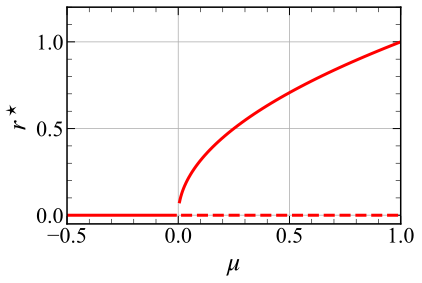

In [13]:
# radial bifurcation diagram
fr = lambda r,µ: µ*r-r**3
BF_diag(fr,-0.05,1.2,-0.5,1,col='r',x_lab='$\mu$',y_lab='$r^\star$')

### Subcritical HB

In [ ]:
# radial bifurcation diagram
fr = lambda r,µ: µ*r+r**3-r**5
BF_diag(fr,-0.05,1.2,-0.4,0.2,col='r',x_lab='$\mu$',y_lab='$r^\star$')

### Example 8.2.1 (Hopf bifurcation)

$\dot{x}=\mu x-y+x y^2$ <br> $\dot{y}=x+\mu y+y^3$

(a) There is a Hopf bifurcation (HB) at $X=(0,0)$ as $\mu$ changes

   - origin is a stable (unstable) spiral for $\mu<0$ ($\mu>0$)
   - there is a HB at $\mu=0$
    
(b) Is the Hopf bifurcation super- or sub-critical?
    
   - HB is subcritical
   - for $\mu<0$, there is an _unstable limit cycle_ surrounding the origin, which is a stable spiral

#### Find fixed points (FPs) and attributes

In [ ]:
# define variables and f1,f2,A  
x,y,µ = sp.symbols('x,y,µ',real=True)

f1 = lambda x,y,µ: µ*x-y+x*y**2 
f2 = lambda x,y,µ: x+µ*y+y**3

A = lambda x,y,µ: sp.Matrix([f1(x,y,µ),f2(x,y,µ)]).jacobian([x,y])
A(x,y,µ)

- Convert from Cartesian to polar coordinates

$x=r\cos\theta$; $y=r\sin\theta$ $\;\Rightarrow\;$ 
$\dot{x}=\dot{r}\cos\theta-r\dot{\theta}\sin\theta$; $\dot{y}=\dot{r}\sin\theta+r\dot{\theta}\cos\theta$

$\Rightarrow \quad \dot{r}=g_1(r,\theta)\equiv\cos\theta f_1(r\cos\theta,r\sin\theta)+\sin\theta f_2(r\cos\theta,r\sin\theta)$

$\Rightarrow \quad \dot{\theta}=g_2(r,\theta)\equiv\cos\theta f_2(r\cos\theta,r\sin\theta)/r-\sin\theta f_1(r\cos\theta,r\sin\theta)/r$

In [ ]:
# convert from Cartesian to polar coordinates
r,r0,q,q0,theta = sp.symbols('r,r0,q,q0,theta',real=True)
g1 = lambda r,q,µ: (sp.cos(q)*f1(r*sp.cos(q),r*sp.sin(q),µ)+sp.sin(q)*f2(r*sp.cos(q),r*sp.sin(q),µ)).simplify()
g2 = lambda r,q,µ: (-sp.sin(q)*f1(r*sp.cos(q),r*sp.sin(q),µ)+sp.cos(q)*f2(r*sp.cos(q),r*sp.sin(q),µ)).simplify()/r
display(Latex(r'$\dot{{r}} = {}$'.format(sp.latex(g1(r,theta,µ)))))
display(Latex(r'$\dot{{\theta}} = {}$'.format(sp.latex(g2(r,theta,µ)))))

$\Rightarrow\;$ there is a single fixed point at the origin ($r=0$)

In [ ]:
# calculate fixed point (FP) attributes

FP=[0,0]
display(Latex(r'Fixed point: ${}$'.format(sp.latex(FP))))

A_FP = lambda µ: A(x,y,µ).subs({x:0,y:0})
display(Latex(r'$A = {}$'.format(sp.latex(A_FP(µ)))))

tau   = A_FP(µ).trace()
display(Latex(r'$\tau = {}$'.format(sp.latex(tau))))
delta = A_FP(µ).det()
display(Latex(r'$\Delta = {}$'.format(sp.latex(delta))))
disc  = tau**2 - 4*delta 
display(Latex(r'$\tau^2-4\Delta = {}$'.format(sp.latex(disc))))

$\Delta>0 \;\Rightarrow\;$ origin is stable (unstable) spiral for $\mu=\tau/2<0$ ($\mu>0$)

#### For $\mu=-0.2$ plot the (unstable) _limit cycle_, along with nearby convergent and divergent trajectories  

In [ ]:
µ_  = -0.2
f1_ = sp.lambdify([x,y],f1(x,y,µ_))
f2_ = sp.lambdify([x,y],f2(x,y,µ_))

# limit cycle (approximate) for µ=-0.2
# [t_LC,sol_LC] = find_LC(T=24,dt=0.01,xy0=[0.6449805,0.])
[t_LC,sol_LC] = txy_traj(f1_,f2_,T=24,dt=0.01,xy0=[0.6449805,0.])

# convergent trajectory
[t,sol1]=txy_traj(f1_,f2_,T=30,dt=1e-2,xy0=[0.64,0.])
# divergent trajectory
[t,sol2]=txy_traj(f1_,f2_,T=10,dt=1e-2,xy0=[0.65,0.])

In [ ]:
# plot LC + nearby convergent/divergent trajectory
fig, ax=plt.subplots(figsize=(5,5))
# ax.plot(sol_LC[:,0],sol_LC[:,1],'r-',lw=2)
ax.plot(sol1[:,0],sol1[:,1],'b-')
ax.plot(sol2[:,0],sol2[:,1],'k-')
ax.plot(sol_LC[:,0],sol_LC[:,1],'r-',lw=2,alpha=0.6)
ax.set_xlim(-1.2,0.8)
ax.set_ylim(-1,1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('$\mu=-0.2$',c='r')
ax.grid()
plt.show()

#### Phase portrait

In [ ]:
# phase portrait

µ_ = -0.2
f1_ = sp.lambdify([x,y],f1(x,y,µ_))
f2_ = sp.lambdify([x,y],f2(x,y,µ_))

x1 = -4; x2 = 4
y1 = -4; y2 = 4

d0 = 2

n1=20; n2=12; n3=10
ppx = lambda x1,x2,nx: np.linspace(x1,x2,nx)
pp1 = lambda nx: np.ones(nx)
    
fig_821, ax = plt.subplots(figsize=(5,5))

# automated streamlines
# PP_2d(x1,x2,y1,y2,f1_,f2_,ax,dens=1.5)

# selected streamlines
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([ppx(x1,x2,n1),pp1(n1)*(-2)]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([ppx(x1,x2,n1),pp1(n1)*2]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([pp1(n3)*x1,ppx(-1.8,1.8,n3)]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([pp1(n3)*x2,ppx(-1.8,1.8,n3)]),ax,col='k',dens=d0)

PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([ppx(0,0.6,3),pp1(3)*0]),ax,col='k',dens=d0)

# plot nulclines
# PP_nc(x1,x2,y1,y2,f1_,f2_,ax)

# display fixed points
# PP_FPs(FPs,tau,delta,ax)

# plot limit cycle
ax.plot(sol_LC[:,0],sol_LC[:,1],'r-',lw=2,alpha=0.8)

ax.set_aspect('equal')
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
# ax.set_xticks(np.arange(-4,5,2))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('$\mu={}$'.format(µ_),c='r')
ax.grid()
plt.show()

## 8.3 Oscillating Chemical Reactions

___BZ reaction___: Chlorine Dioxide-Iodine-Malonic Acid Reaction [$ClO_2 - I_2 - MA$]

$\dot{x}= a-x-\frac{4xy}{1+x^2}$ <br> $\dot{y} = bx\left(1-\frac{y}{1+x^2} \right)$

$x\equiv c_{I^-}$ concentration of $I^-$ ions

$y\equiv c_{ClO_2^-}$ concentration of $ClO_2^-$ ions

$a,b>0$ are rate constants

#### Fixed point

In [14]:
# define variables and f1,f2,A  
x,y,a,b = sp.symbols('x,y,a,b',nonnegative=True)

f1 = lambda x,y,: a-x-4*x*y/(1+x**2)  
f2 = lambda x,y,: b*x*(1-y/(1+x**2))

A = lambda x,y: sp.Matrix([f1(x,y),f2(x,y)]).jacobian([x,y])
A(x,y)

Matrix([
[     8*x**2*y/(x**2 + 1)**2 - 4*y/(x**2 + 1) - 1, -4*x/(x**2 + 1)],
[2*b*x**2*y/(x**2 + 1)**2 + b*(-y/(x**2 + 1) + 1), -b*x/(x**2 + 1)]])

In [15]:
# calculate fixed point (FP) and attributes

FP = sp.solve((f1(x,y),f2(x,y)),x,y)[0]
display(Latex('Fixed point: ${}$'.format(sp.latex(FP)))) 

A_FP = lambda a,b: A(x,y).subs({x:FP[0],y:FP[1]})
display(Latex(r'$A = {}$'.format(sp.latex(A_FP(a,b)))))

tau   = A_FP(a,b).trace().simplify()
display(Latex(r'$\tau = {}$'.format(sp.latex(tau))))
delta = A_FP(a,b).det().simplify()
display(Latex(r'$\Delta = {}$'.format(sp.latex(delta))))
disc  = (tau**2 - 4*delta).simplify() 
display(Latex(r'$\tau^2-4\Delta = {}$'.format(sp.latex(disc))))
x0 = FP[0]; y0 = FP[1]

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#### Stability diagram [$b$ vs $a$]

In [16]:
# tau > 0 for b < b_c
b_c = sp.solve(tau*(a**2+25),b)[0]
display(Latex(r'FP is a repeller if $\tau>0$ for $b<b_c={}$. Hopf bifurcation occurs at $b=b_c$'.format(sp.latex(b_c))))

<IPython.core.display.Latex object>

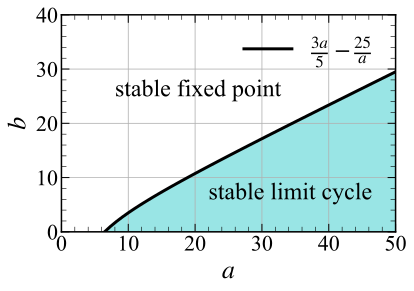

In [17]:
a0 = float(sp.solve(b_c,a)[0])
a_ = np.linspace(a0,50,50)
b_ = [b_c.subs(a,z) for z in a_]
fb_= interpolate(a_,b_)
fig_83_BD, ax=plt.subplots(figsize=(6,4))
ax.plot(a_,b_,'k-',lw=3,label='${}$'.format(sp.latex(b_c)))
ax.fill_between(a_,fb_(a_),color='c',alpha=0.4)
ax.set_xlim(0,50)
ax.set_ylim(0,40)
ax.set_xlabel('$a$')
ax.set_ylabel('$b$')
ax.text(8,25,'stable fixed point',fontsize=24)
ax.text(22,6, 'stable limit cycle',fontsize=24)
ax.grid()
ax.legend(fontsize=24)
plt.show()

#### Phase portrait  [$b>b_c$]

In [ ]:
# phase portrait for b > b_c

x1 = 0; x2 = 5
y1 = 0; y2 = 10

a_ = 10 # b_c = 7/2 = 3.5
b_ = 4  # > b_c
x0_=x0.subs(a,a_); y0_=y0.subs(a,a_)

f1_ = sp.lambdify([x,y],f1(x,y).subs(a,a_))
f2_ = sp.lambdify([x,y],f2(x,y).subs(b,b_))

d0 = 1.4

n1=20; n2=12; n3=6
ppx = lambda x1,x2,nx: np.linspace(x1,x2,nx)
pp1 = lambda nx: np.ones(nx)
    
fig_83_PP, ax = plt.subplots(figsize=(5,5))
# PP_2d(x1,x2,y1,y2,f1_,f2_,ax,dens=d0)

d0 = 3
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([pp1(n2)*x1,ppx(y1,y2,n2)]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([ppx(1.5,x2,n3),pp1(n3)*y1]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([ppx(0.5,2.5,n3),pp1(n3)*y2]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([ppx(2,2.5,n3),pp1(n3)*y0_]),ax,col='k',dens=d0)

# fixed point
ax.plot(x0_,y0_,'o-',ms=8,mec='r',mfc='r')

ax.set_title('$a={},\;b={}>b_c=3.5$'.format(a_,b_),color='b')
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.grid()
plt.show()

#### Phase portrait  [$b<b_c$]

In [ ]:
# functions to calculate trajectory {x(t),y(t)} numerically for given {x0,y0}
# define RHS 
def RHS(xy,t):
    x,y=xy
    return [f1_(x,y),f2_(x,y)]
# solve ode
def txy(T,dt,xy0):
    t = np.arange(0,T+dt,dt)
    return [t,odeint(RHS,xy0,t)]

def find_LC(T,dt,xy0):
    return txy(T,dt,xy0)    

In [ ]:
# phase portrait for b < b_c

x1 = 0; x2 = 5
y1 = 0; y2 = 10

a_ = 10 # b_c = 7/2 = 3.5
b_ = 2  # < b_c
x0_=x0.subs(a,a_); y0_=y0.subs(a,a_)

f1_ = sp.lambdify([x,y],f1(x,y).subs(a,a_))
f2_ = sp.lambdify([x,y],f2(x,y).subs(b,b_))

d0 = 1.4

n1=20; n2=12; n3=5
ppx = lambda x1,x2,nx: np.linspace(x1,x2,nx)
pp1 = lambda nx: np.ones(nx)
    
fig_83_PP2, ax = plt.subplots(figsize=(5,5))
# PP_2d(x1,x2,y1,y2,f1_,f2_,ax,dens=d0)

d0 = 5
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([pp1(n2)*x1,ppx(y1,y2,n2)]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([ppx(1.5,x2,n3),pp1(n3)*y1]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([ppx(0.5,2.5,n3),pp1(n3)*y2]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([ppx(2,2.5,n3),pp1(n3)*y0_]),ax,col='k',dens=d0)

# limit cycle
T=20; dt=0.01; xy0=[3,6]
[t,sol] = find_LC(T,dt,xy0)
s1 = int(5/dt) 
ax.plot(sol[s1:,0],sol[s1:,1],'r-',lw=2,alpha=0.8)

ax.set_title('$a={},\;b={}<b_c=3.5$'.format(a_,b_),color='b')
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.grid()
plt.show()

#### Period of the limit cycle

The period of the limit cycle for $b=b_c-0$ is $T=2\pi/\omega=2\pi/\sqrt{\Delta(a,b_c)}$

In [ ]:
T = lambda a: 2*sp.pi/sp.sqrt(delta.subs(b,b_c)).simplify()
display(Latex('$T={}$'.format(sp.latex(T(a)))))
T_ = sp.lambdify(a,T(a))

In [ ]:
a_ = np.linspace(a0*1.001,100,80)
fig_83_T, ax=plt.subplots(figsize=(6,4))
ax.plot(a_,T_(a_),'k-',lw=3)
ax.set_xlim(0,100)
ax.set_ylim(1,3)
ax.set_xlabel('$a$')
ax.set_ylabel('$T$')
plt.show()

## 8.4 Global bifurcations of cycles

### 3) Homoclinic Bifurcations

#### Find fixed points (FPs) and attributes

In [18]:
# define variables and f1,f2,A  
x,y,µ = sp.symbols('x,y,µ',nonnegative=True)

f1 = lambda x,y,: y  
f2 = lambda x,y,: µ*y+x-x**2+x*y

FPs, tau, delta, disc, mu, V = get_FP_data(f1,f2,tab=False)

Fixed points:  [{x: 0, y: 0}, {x: 1, y: 0}]


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Matrix([
[0, 1],
[1, µ]])

Matrix([
[ 0,     1],
[-1, µ + 1]])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#### Phase portrait

In [ ]:
# phase portrait
x1 = -2; x2 = 2
y1 = -2; y2 = 2

n1=15; n2=10; n3=5
ppx = lambda x1,x2,nx: np.linspace(x1,x2,nx)
pp1 = lambda nx: np.ones(nx)

f1_ = sp.lambdify([x,y],f1(x,y))

µ_c = -0.8645
@interact(µ_=[-1,-0.92,µ_c,-0.8,-0.7],sL=False)
def update(µ_=-1,sL=False):
    f2_= sp.lambdify([x,y], f2(x,y).subs(µ,µ_))
    fig_hB, ax = plt.subplots(figsize=(6,6))
    if sL: PP_2d(x1,x2,y1,y2,f1_,f2_,ax,dens=1.5,col='gray')

    d0=3
#     if sL:
#         PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([ppx(x1,-1.25,n1),pp1(n1)*2.9]),ax,col='gray',dens=d0)
#         PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([ppx(x1,-0.4,n3),pp1(n3)*y1]),ax,col='gray',dens=d0)
#         PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([pp1(n1)*0,ppx(y1,2.9,n1)]),ax,col='gray',dens=d0)

#     FPs and streamlines along eigenvector directions
    s = 100
    
    for j in np.arange(len(FPs)):    
        FP_ = np.array(FPs[j],dtype=float) 
        if tau[j]<0 and delta[j]>0:
            ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='r',mec='r',lw=2)
        else:
            ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='w',mec='r',lw=2)
        V1  = np.array([v.subs(µ,µ_) for v in V[j][0]])
        V2  = np.array([v.subs(µ,µ_) for v in V[j][1]])
        d0 = 3
        if j==0: PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([FP_+V1/s]).T,ax,col='b',dens=d0,ar_s='->')
        if j==0: PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([FP_-V1/s]).T,ax,col='b',dens=d0,ar_s='->')
        if j==0: PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([FP_+V2/s]).T,ax,col='b',dens=d0,ar_s='->')
            

    ax.set_aspect('equal')
    ax.set_xlim(x1,x2)
    ax.set_xticks(np.arange(-2,2.5,1))
    ax.set_ylim(y1,y2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('$\mu={}$'.format(µ_),c='r')
    ax.grid()
    plt.show()

## 8.5 Josephson Junction

Equation of motion for the phase $\phi(\tau)$ in dimensionless units: $\phi''+\alpha\phi'+\sin\phi=I$

Equivalent to the 2D dynamical system

$\phi'=y$

$y'=I-\sin\phi-\alpha y$ 

where $\phi\in[0,2\pi)$ and $y\in\mathbb{R}$. In addition, $I=I_B/I_c$, time unit ${\cal T}=(\hbar C/2eI_c)^{1/2}$, and dimensionless damping $\alpha=(\hbar/2eI_cR^2C)^{1/2}$. 

#### Fixed points (FPs) and attributes

In [ ]:
# define variables and f1,f2,A
# x=phi; a=alpha; b=I
x,y,a,b = sp.symbols('x,y,a,b',real=True)

f1 = lambda x,y,: y  
f2 = lambda x,y,: b-sp.sin(x)-a*y

FPs, tau, delta, disc, mu, V = get_FP_data(f1,f2,tab=False)

For $b=I<1$ there are two fixed points:

1) {$\pi-\arcsin(I)$, 0} is a saddle

2) {$\arcsin(I)$, 0} is a sink

   - node if $\alpha > 4\sqrt{1-I^2}$
   
   - spiral if $\alpha < 4\sqrt{1-I^2}$

#### Phase portrait

In [ ]:
FPs_  = sp.lambdify([a,b],FPs)
tau_  = sp.lambdify([a,b],tau)
delta_= sp.lambdify([a,b],delta)
disc_ = sp.lambdify([a,b],disc)
V_    = sp.lambdify([a,b],V)

In [ ]:
# phase portrait
x1 = 0; x2 = 2*np.pi
y1 = -4; y2 = 4

n1=15; n2=10; n3=5
ppx = lambda x1,x2,nx: np.linspace(x1,x2,nx)
pp1 = lambda nx: np.ones(nx)

f1_ = sp.lambdify([x,y],f1(x,y))

a_ = 0.5
@interact(b_=(0.2,0.9,0.1),sL=True)
def update(b_=0.9,sL=True):
    f2_= sp.lambdify([x,y], f2(x,y).subs({b:b_,a:a_}))
    fig_JJ, ax = plt.subplots(figsize=(6,6))
    if sL: PP_2d(x1,x2,y1,y2,f1_,f2_,ax,dens=1.5,col='gray')

    d0=3
#     if sL:
#         PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([ppx(x1,-1.25,n1),pp1(n1)*2.9]),ax,col='gray',dens=d0)
#         PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([ppx(x1,-0.4,n3),pp1(n3)*y1]),ax,col='gray',dens=d0)
#         PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([pp1(n1)*0,ppx(y1,2.9,n1)]),ax,col='gray',dens=d0)

#     FPs and streamlines along eigenvector directions        
    for j in np.arange(len(FPs)):    
        FP_ = np.asarray(FPs_(a_,b_))[j]
        if tau_(a_,b_)[j]<0 and delta_(a_,b_)[j]>0:
            ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='r',mec='r',lw=2)
        else:
            ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='w',mec='r',lw=2)
        if j==0:
            V1 = np.asarray(V_(a_,b_))[j]
            d0 = 3; s = 10
            PP_2d_sp(x1,x2,y1,y2,f1_,f2_,(FP_+V1/s).T,ax,col='b',dens=d0,ar_s='->')
            PP_2d_sp(x1,x2,y1,y2,f1_,f2_,(FP_-V1/s).T,ax,col='b',dens=d0,ar_s='->')
            
# limit cycle
    T=25; dt=0.01; xy0=[2,3.5]
    [t,sol] = txy_traj(f1_,f2_,T,dt,xy0)
    s1 = int(15/dt) 
    # sample trajectory starting at xy0
    ax.plot(np.mod(sol[:,0],2*np.pi),sol[:,1],'o',ms=0.5,c='m',alpha=0.8)
    # limit cycle (t > s1.dt)
    ax.plot(np.mod(sol[s1:,0],2*np.pi),sol[s1:,1],'o',ms=2,c='r',alpha=0.8)

    ax.set_xlim(x1,x2)
    ax.set_ylim(y1,y2)
    ax.set_xlabel('$\phi$')
    ax.set_ylabel('$y$')
    ax.set_title(r'$\alpha={}$'.format(a_) +' ,   '+ '$I={}$'.format(b_),c='r')
    ax.grid()
    plt.show()

#### Plot $\phi(t)$ and $y(t)$ for different values of $a=\alpha$ and $I=b$

In [ ]:
a1_ = 0.5
b1_ = 1

f2_= sp.lambdify([x,y], f2(x,y).subs({b:b1_,a:a1_}))

fig, ax=plt.subplots(2,1,figsize=(6,6),sharex=True,gridspec_kw=dict(height_ratios=[1,1],hspace=0.02))
T=45; dt=0.01; xy0=[2,3.5]
[t,sol] = txy_traj(f1_,f2_,T,dt,xy0)
t1=30; s1 = int(t1/dt) 
# sample trajectory starting at xy0
ax[0].plot(t[:],np.mod(sol[:,0],2*np.pi),'o',ms=0.5,c='gray',alpha=0.8)
ax[1].plot(t[:],sol[:,1],'o',ms=0.5,c='gray',alpha=0.8)
# limit cycle (t > s1.dt)
ax[0].plot(t[s1:],np.mod(sol[s1:,0],2*np.pi),'o',ms=2,c='k',alpha=0.8)
ax[1].plot(t[s1:],sol[s1:,1],'o',ms=2,c='k',alpha=0.8)

ax[0].set_ylim(0,2*np.pi)
ax[0].set_xlim(0,T)
ax[1].set_xlabel('$t$')
ax[0].set_ylabel('$\phi$')
ax[1].set_ylabel('$y$')
[ax_.grid() for ax_ in ax]
plt.show()

#### $\langle V\rangle/I_cR=\bar{y}$ vs $I/I_c=b$

In [ ]:
a1_=0.5
T=180; dt=0.01; t1=30; xy0=[2,3.5]
s1=int(t1/dt)
bb1=0.5; bb2=2; dbb=0.02
bb = np.arange(bb1,bb2,dbb)
vv = []
for b1_ in bb:
    f2_= sp.lambdify([x,y], f2(x,y).subs({b:b1_,a:a1_}))
    [t,sol] = txy_traj(f1_,f2_,T,dt,xy0)
    vv = np.append(vv,interpolate(t[s1:],sol[s1:,1]).integral(t1,T)/(T-t1))

In [ ]:
fig_VI, ax=plt.subplots(figsize=(6,4))
ax.plot(bb,vv,'b-',lw=3);
ax.plot([0,1],[0,0],'b-',lw=3)
ax.plot([0,bb2],[0,bb2/a1_],'k--',lw=1)
ax.plot([1,1],[0,vv[np.round(bb,2)==1][0]],'b--',lw=1)
ax.grid()
ax.set_ylim(-0.06,vv.max()*1.1)
ax.set_xlim(0,bb2)
ax.set_xlabel('$I/I_c$')
ax.set_yticks(np.arange(1,5,1))
ax.set_ylabel('$V/I_cR$')
plt.show()